In [1]:
!pip install numpy pandas scikit-learn torch transformers sentence-transformers nltk matplotlib seaborn scipy



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### IMPORT ALL LIBRARIES

In [33]:
import numpy as np
import pandas as pd
import torch
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import pos_tag, word_tokenize
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from sentence_transformers import SentenceTransformer
from transformers import T5EncoderModel, T5Tokenizer, CLIPTokenizer, CLIPTextModel
from tqdm import tqdm

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /Users/prisha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/prisha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Load Dataset

In [11]:
stimuli = [line.strip() for line in open('data/stimuli.txt').readlines()]
subj1 = np.load('data/subj1.npy', allow_pickle=True).item()
subj2 = np.load('data/subj2.npy', allow_pickle=True).item()
subjects = {'subj1': subj1, 'subj2': subj2}
ROIs = ['language', 'vision', 'task', 'dmn']

print(f"Number of stimuli: {len(stimuli)}")
print(f"Length of Subject 1 data: {len(subj1)}")
print(f"Length of Subject 2 data: {len(subj2)}")
print(f"Keys in Subject 1 data: {list(subj1.keys())}") 
print(f"Keys in Subject 2 data: {list(subj2.keys())}") 

Number of stimuli: 627
Length of Subject 1 data: 4
Length of Subject 2 data: 4
Keys in Subject 1 data: ['language', 'vision', 'dmn', 'task']
Keys in Subject 2 data: ['language', 'vision', 'dmn', 'task']


### Sentence Embedding

In [12]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2') 
t5_model = T5EncoderModel.from_pretrained('t5-small')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
clip_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
clip_model = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
def get_t5_embeddings(sentences):
    inputs = t5_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = t5_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()


In [14]:
def get_clip_embeddings(sentences):
    inputs = clip_tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = clip_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

In [17]:
print("Generating Embeddings...")
sbert_embeddings = sbert_model.encode(stimuli, show_progress_bar=True)
t5_embeddings = get_t5_embeddings(stimuli)
clip_embeddings = get_clip_embeddings(stimuli)

print("Calculating Length of Embeddings...")   
sbert_embeddings_len = len(sbert_embeddings)
t5_embeddings_len = len(t5_embeddings)
clip_embeddings_len = len(clip_embeddings)

print(f"Length of SBERT Embeddings: {sbert_embeddings_len}")
print(f"Length of T5 Embeddings: {t5_embeddings_len}")
print(f"Length of CLIP Embeddings: {clip_embeddings_len}")

# Print Length of each embedding
print(f"Length of SBERT Embeddings: {sbert_embeddings.shape}")
print(f"Length of T5 Embeddings: {t5_embeddings.shape}")    
print(f"Length of CLIP Embeddings: {clip_embeddings.shape}")


Generating Embeddings...


Batches: 100%|██████████| 20/20 [00:00<00:00, 46.66it/s]


Calculating Length of Embeddings...
Length of SBERT Embeddings: 627
Length of T5 Embeddings: 627
Length of CLIP Embeddings: 627
Length of SBERT Embeddings: (627, 384)
Length of T5 Embeddings: (627, 512)
Length of CLIP Embeddings: (627, 512)


In [23]:

# Combine all embeddings
embeddings = {
    'SBERT': sbert_embeddings,
    'T5': t5_embeddings,
    'CLIP': clip_embeddings
}

### Evaluation Metrics

In [18]:
def cosine_distance(u, v):
    return 1 - cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0][0]

def v2v_accuracy(y_true, y_pred):
    N = len(y_true)
    correct = 0
    for i in range(0, N, 2):
        if i + 1 >= N:
            break
        score1 = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0] + \
                 cosine_similarity(y_true[i+1].reshape(1, -1), y_pred[i+1].reshape(1, -1))[0][0]
        score2 = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i+1].reshape(1, -1))[0][0] + \
                 cosine_similarity(y_true[i+1].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0]
        if score1 > score2:
            correct += 1
    return correct / (N // 2)

def pearson_corr(y_true, y_pred):
    return np.mean([pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])])

In [19]:
# ========== 4. Train Brain Encoder ==========
def train_encoder(X, Y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    v2v_scores = []
    pc_scores = []
    
    for train_idx, test_idx in kf.split(X):
        model = Ridge(alpha=1.0)
        model.fit(X[train_idx], Y[train_idx])
        preds = model.predict(X[test_idx])
        
        v2v_scores.append(v2v_accuracy(Y[test_idx], preds))
        pc_scores.append(pearson_corr(Y[test_idx], preds))
    
    return np.mean(v2v_scores), np.mean(pc_scores)

In [34]:
def mask_pos(sentences, target_pos):
    masked = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        tags = pos_tag(tokens)
        new_tokens = [token for token, pos in tags if not pos.startswith(target_pos)]
        masked.append(' '.join(new_tokens))
    return masked

def representational_similarity(X, Y):
    sim_X = cosine_similarity(X)
    sim_Y = cosine_similarity(Y)
    return spearmanr(sim_X.flatten(), sim_Y.flatten())[0]

In [24]:
results = []

for subj_name, subj_data in subjects.items():
    for roi in ROIs:
        print(f"Training for {subj_name} - {roi}")
        Y = subj_data[roi]
        
        for emb_name, X in embeddings.items():
            v2v, pc = train_encoder(X, Y)
            rsa = representational_similarity(X, Y)
            results.append({
                'Subject': subj_name,
                'ROI': roi,
                'Embedding': emb_name,
                '2V2 Accuracy': v2v,
                'Pearson Correlation': pc,
                'RSA': rsa
            })

results_df = pd.DataFrame(results)
print(results_df)

Training for subj1 - language
Training for subj1 - vision
Training for subj1 - task
Training for subj1 - dmn
Training for subj2 - language
Training for subj2 - vision
Training for subj2 - task
Training for subj2 - dmn
   Subject       ROI Embedding  2V2 Accuracy  Pearson Correlation       RSA
0    subj1  language     SBERT      0.830056             0.305247  0.016020
1    subj1  language        T5      0.785100             0.289146 -0.121716
2    subj1  language      CLIP      0.718228             0.187125  0.120852
3    subj1    vision     SBERT      0.788377             0.300555  0.030532
4    subj1    vision        T5      0.759396             0.305798 -0.097576
5    subj1    vision      CLIP      0.724578             0.204458  0.098814
6    subj1      task     SBERT      0.740143             0.226825  0.033572
7    subj1      task        T5      0.721147             0.204358 -0.079537
8    subj1      task      CLIP      0.692473             0.150937  0.079181
9    subj1       dmn  

In [36]:
POS_tags = {'Nouns': 'NN', 'Verbs': 'VB', 'Adjectives': 'JJ'}

masked_results = []
for pos_name, pos_prefix in POS_tags.items():
    masked_sentences = mask_pos(stimuli, pos_prefix)
    masked_embeds = sbert_model.encode(masked_sentences, show_progress_bar=False)
    
    for subj_name, subj_data in subjects.items():
        for roi in ROIs:
            print(f"Training for {subj_name} - {roi} with masked {pos_name}")
            Y = subj_data[roi]
            v2v, pc = train_encoder(masked_embeds, Y)
            masked_results.append({
                'Subject': subj_name,
                'ROI': roi,
                'POS Masked': pos_name,
                '2V2 Accuracy': v2v,
                'Pearson Correlation': pc
            })

Training for subj1 - language with masked Nouns
Training for subj1 - vision with masked Nouns
Training for subj1 - task with masked Nouns
Training for subj1 - dmn with masked Nouns
Training for subj2 - language with masked Nouns
Training for subj2 - vision with masked Nouns
Training for subj2 - task with masked Nouns
Training for subj2 - dmn with masked Nouns
Training for subj1 - language with masked Verbs
Training for subj1 - vision with masked Verbs
Training for subj1 - task with masked Verbs
Training for subj1 - dmn with masked Verbs
Training for subj2 - language with masked Verbs
Training for subj2 - vision with masked Verbs
Training for subj2 - task with masked Verbs
Training for subj2 - dmn with masked Verbs
Training for subj1 - language with masked Adjectives
Training for subj1 - vision with masked Adjectives
Training for subj1 - task with masked Adjectives
Training for subj1 - dmn with masked Adjectives
Training for subj2 - language with masked Adjectives
Training for subj2 - v

### Visualization - WITHOUT MASKING 

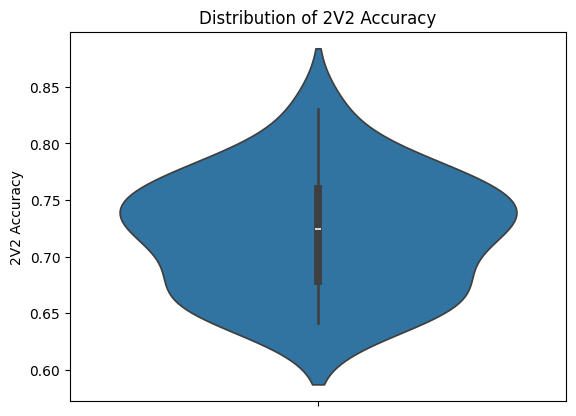

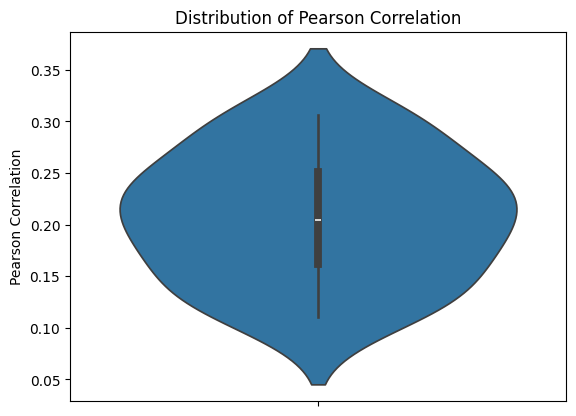

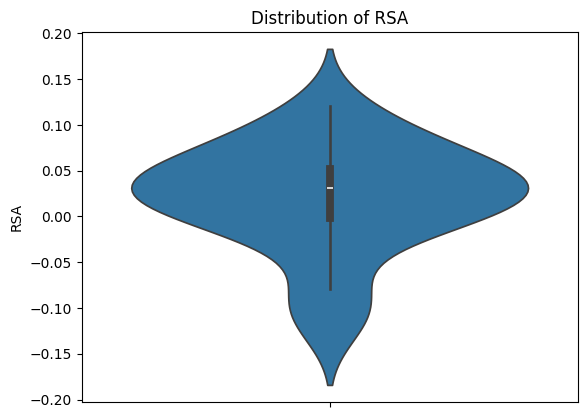

In [37]:
for metric in ['2V2 Accuracy', 'Pearson Correlation', 'RSA']:
    sns.violinplot(data=results_df, y=metric)
    plt.title(f'Distribution of {metric}')
    plt.show()

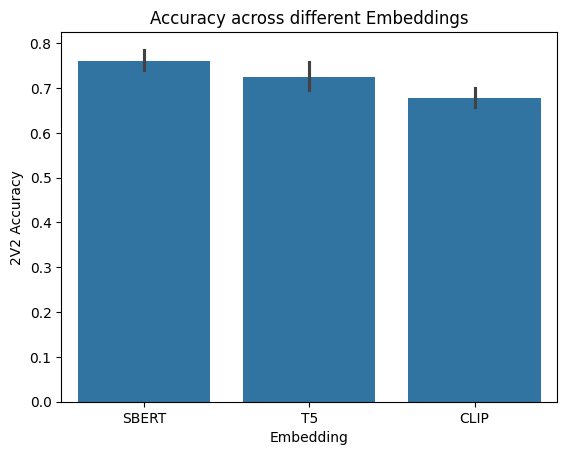

In [38]:
sns.barplot(data=results_df, x='Embedding', y='2V2 Accuracy')
plt.title('Accuracy across different Embeddings')
plt.show()


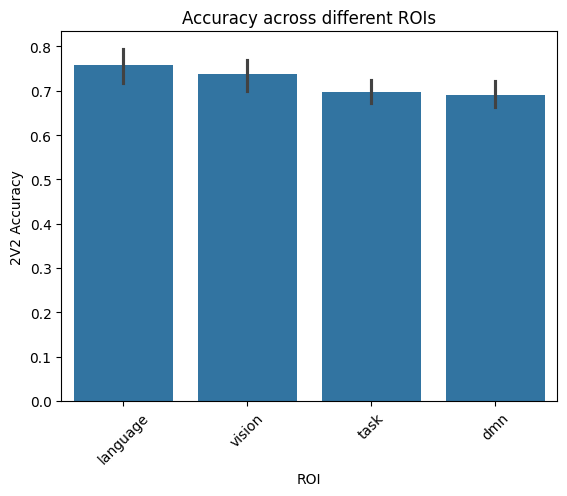

In [39]:

sns.barplot(data=results_df, x='ROI', y='2V2 Accuracy')
plt.title('Accuracy across different ROIs')
plt.xticks(rotation=45)
plt.show()


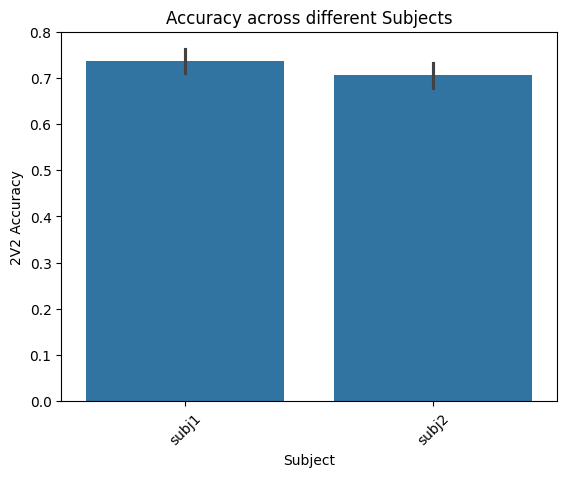

In [40]:

sns.barplot(data=results_df, x='Subject', y='2V2 Accuracy')
plt.title('Accuracy across different Subjects')
plt.xticks(rotation=45)
plt.show()

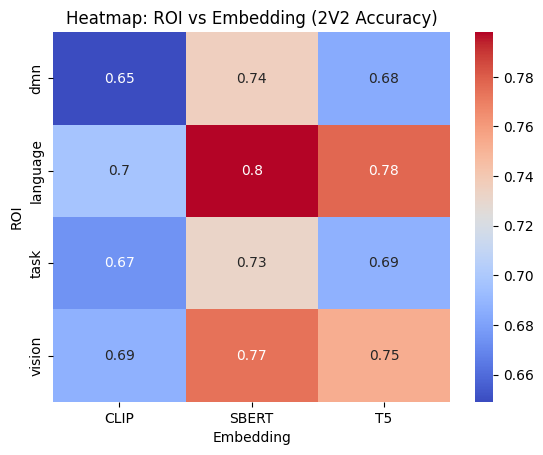

In [41]:
pivot = results_df.pivot_table(index='ROI', columns='Embedding', values='2V2 Accuracy')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Heatmap: ROI vs Embedding (2V2 Accuracy)')
plt.show()

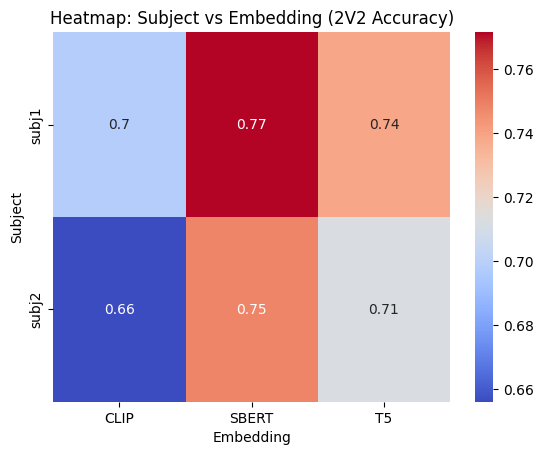

In [42]:
pivot2 = results_df.pivot_table(index='Subject', columns='Embedding', values='2V2 Accuracy')
sns.heatmap(pivot2, annot=True, cmap='coolwarm')
plt.title('Heatmap: Subject vs Embedding (2V2 Accuracy)')
plt.show()

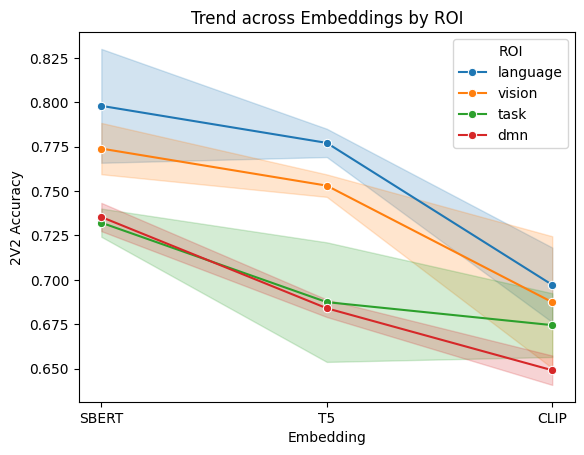

In [43]:
sns.lineplot(data=results_df, x='Embedding', y='2V2 Accuracy', hue='ROI', marker='o')
plt.title('Trend across Embeddings by ROI')
plt.show()


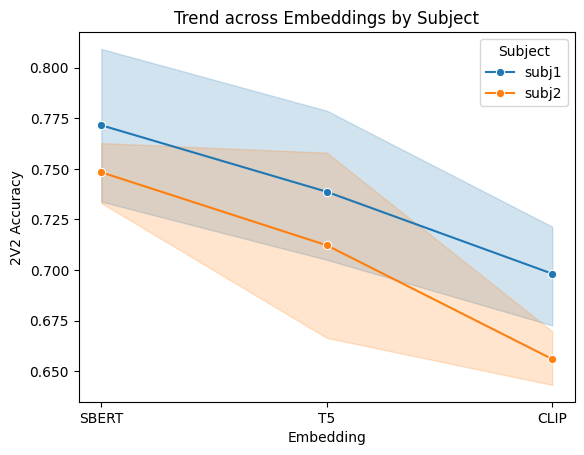

In [44]:
sns.lineplot(data=results_df, x='Embedding', y='2V2 Accuracy', hue='Subject', marker='o')
plt.title('Trend across Embeddings by Subject')
plt.show()

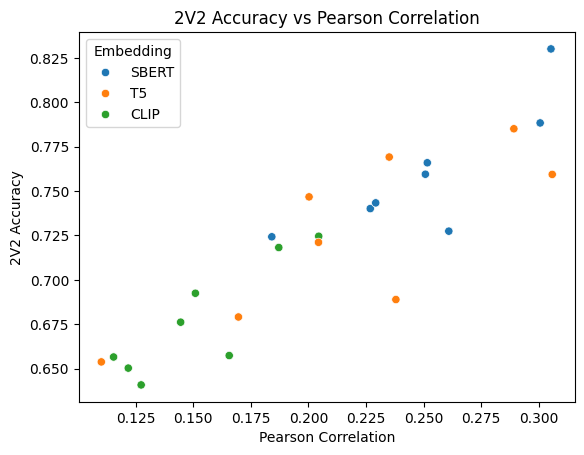

In [45]:
sns.scatterplot(data=results_df, x='Pearson Correlation', y='2V2 Accuracy', hue='Embedding')
plt.title('2V2 Accuracy vs Pearson Correlation')
plt.show()

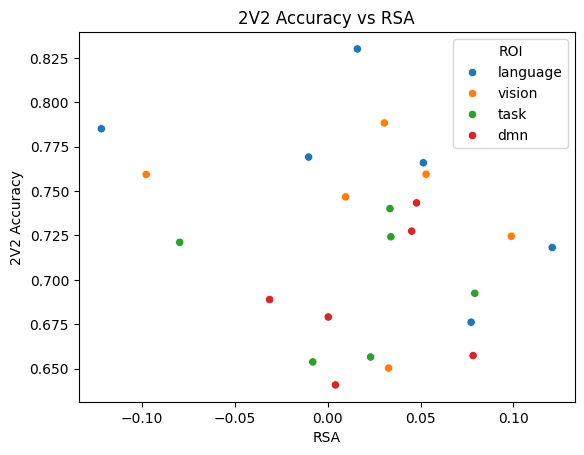

In [46]:
sns.scatterplot(data=results_df, x='RSA', y='2V2 Accuracy', hue='ROI')
plt.title('2V2 Accuracy vs RSA')
plt.show()

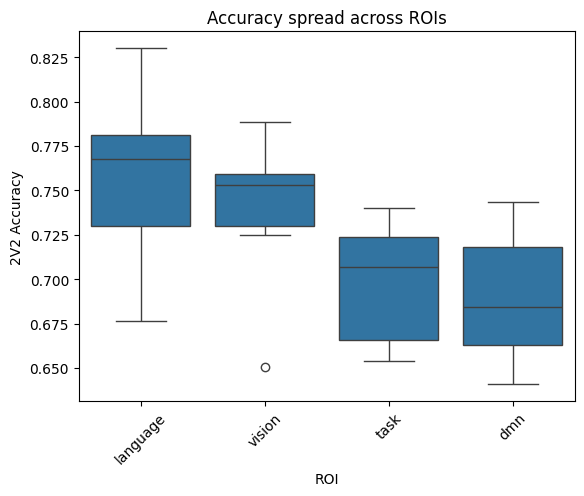

In [49]:
sns.boxplot(data=results_df, x='ROI', y='2V2 Accuracy')
plt.title('Accuracy spread across ROIs')
plt.xticks(rotation=45)
plt.show()


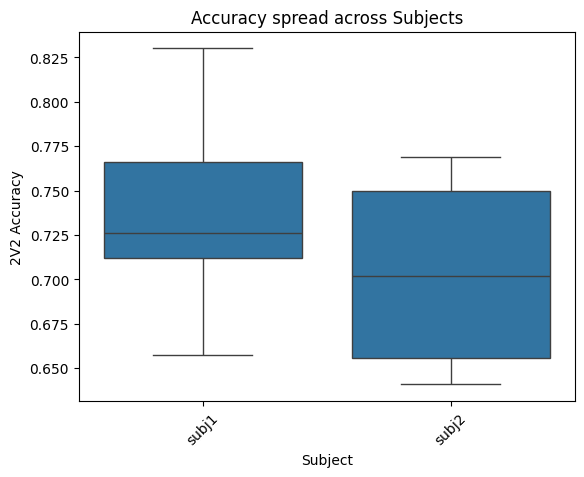

In [50]:

sns.boxplot(data=results_df, x='Subject', y='2V2 Accuracy')
plt.title('Accuracy spread across Subjects')
plt.xticks(rotation=45)
plt.show()

### MASKED - VISUALIZATION

The happy (adjective) dog (noun) runs (verb) fast.

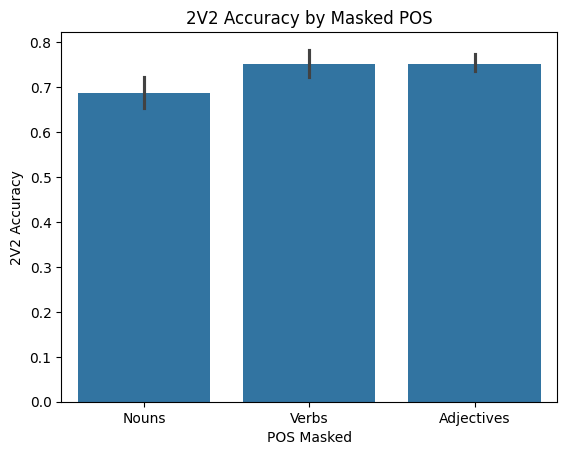

In [51]:
masked_df = pd.DataFrame(masked_results)

sns.barplot(data=masked_df, x='POS Masked', y='2V2 Accuracy')
plt.title('2V2 Accuracy by Masked POS')
plt.show()

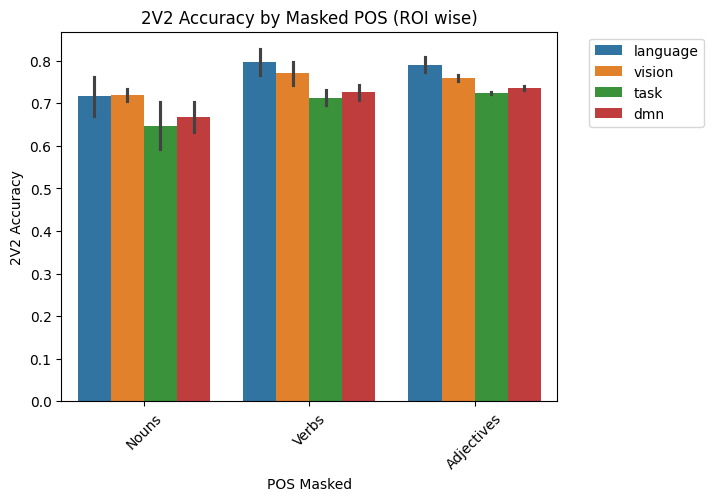

In [52]:
sns.barplot(data=masked_df, x='POS Masked', y='2V2 Accuracy', hue='ROI')
plt.title('2V2 Accuracy by Masked POS (ROI wise)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

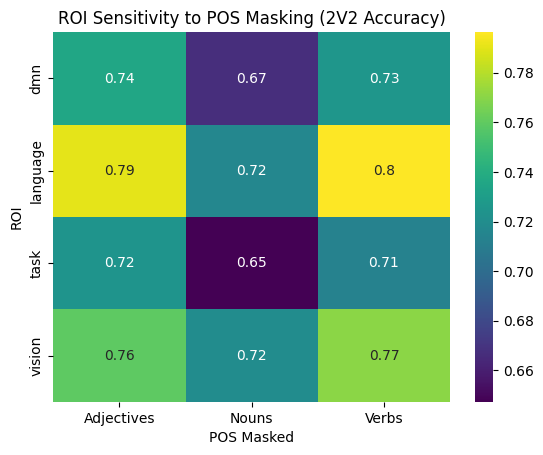

In [54]:
pivot = masked_df.pivot_table(index='ROI', columns='POS Masked', values='2V2 Accuracy')
sns.heatmap(pivot, annot=True, cmap='viridis')
plt.title('ROI Sensitivity to POS Masking (2V2 Accuracy)')
plt.show()

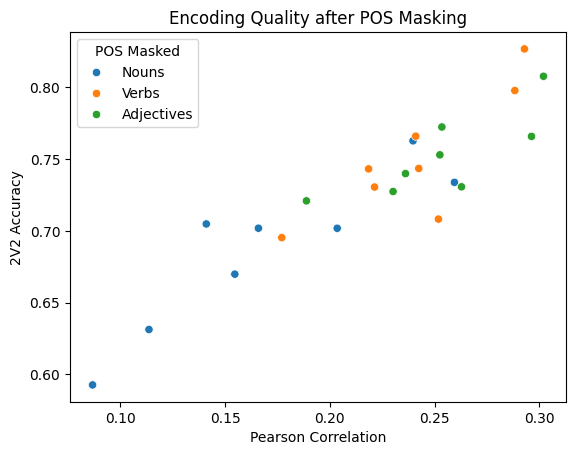

In [55]:
sns.scatterplot(data=masked_df, x='Pearson Correlation', y='2V2 Accuracy', hue='POS Masked')
plt.title('Encoding Quality after POS Masking')
plt.show()

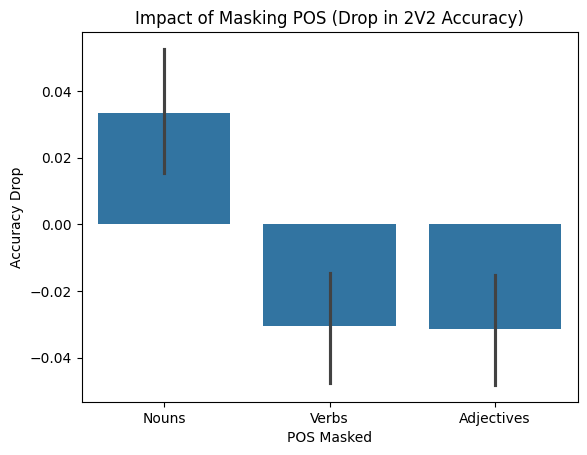

In [56]:
# Merge original (no masking) and masked
unmasked = results_df[['Subject', 'ROI', '2V2 Accuracy']].copy()
unmasked = unmasked.rename(columns={'2V2 Accuracy': 'Original Accuracy'})

merged = masked_df.merge(unmasked, on=['Subject', 'ROI'])
merged['Accuracy Drop'] = merged['Original Accuracy'] - merged['2V2 Accuracy']

sns.barplot(data=merged, x='POS Masked', y='Accuracy Drop')
plt.title('Impact of Masking POS (Drop in 2V2 Accuracy)')
plt.show()

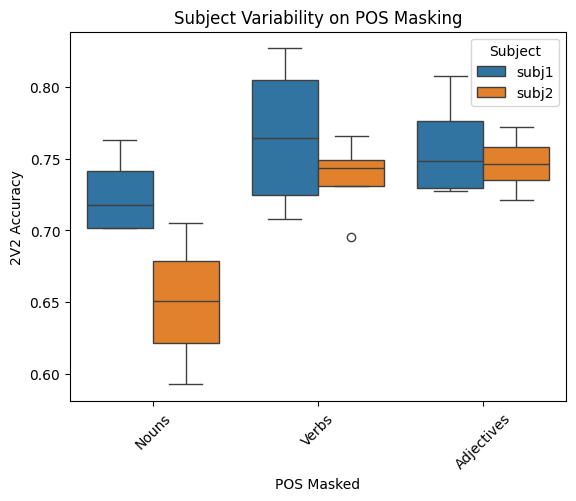

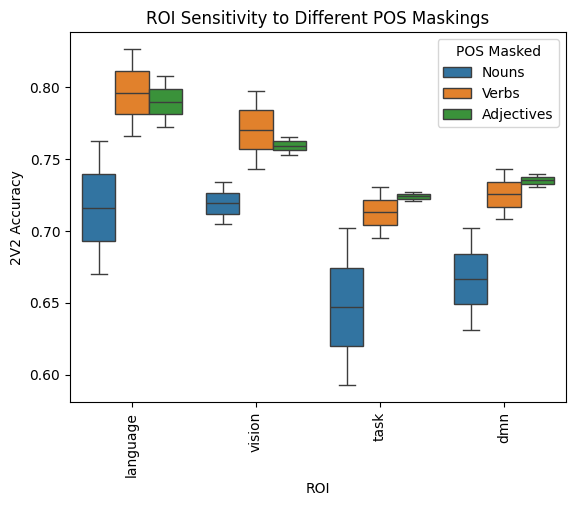

In [57]:
sns.boxplot(data=masked_df, x='POS Masked', y='2V2 Accuracy', hue='Subject')
plt.title('Subject Variability on POS Masking')
plt.xticks(rotation=45)
plt.show()

sns.boxplot(data=masked_df, x='ROI', y='2V2 Accuracy', hue='POS Masked')
plt.title('ROI Sensitivity to Different POS Maskings')
plt.xticks(rotation=90)
plt.show()